In [56]:
import torch
from torch_cluster import radius_graph
from torch_geometric.data import Data, DataLoader
from torch_scatter import scatter

from e3nn import o3
from e3nn.nn import FullyConnectedNet, Gate
from e3nn.o3 import FullyConnectedTensorProduct
from e3nn.math import soft_one_hot_linspace
from e3nn.util.test import assert_equivariant


In [72]:
Y0 = o3.Irrep("0e")
print('Y0 info: dim, l, parity = ',Y0.dim, Y0.l, Y0.p)
Y1 = o3.Irrep("1o")
print('Y1 info: dim, l, parity = ',Y1.dim, Y1.l, Y1.p)
Y2 = o3.Irrep("2e")
print('Y2 info: dim, l, parity = ',Y2.dim, Y2.l, Y2.p)
Y3 = o3.Irrep("3o")
print('Y3 info: dim, l, parity = ',Y3.dim, Y3.l, Y3.p)
Y4 = o3.Irrep("4e")
print('Y4 info: dim, l, parity = ',Y4.dim, Y4.l, Y4.p)


Y0 info: dim, l, parity =  1 0 1
Y1 info: dim, l, parity =  3 1 -1
Y2 info: dim, l, parity =  5 2 1
Y3 info: dim, l, parity =  7 3 -1
Y4 info: dim, l, parity =  9 4 1


In [73]:
# show the xyz convention : Y^(l=1) \propotional r 
x = torch.tensor([1.0,0,0])
print(r"$Y^{1}( \hat{x} )$ = ", o3.spherical_harmonics(Y1.l,x,normalize=True))
x = torch.tensor([0.0,1,0])
print(r"$Y^{1}( \hat{y} )$ = ", o3.spherical_harmonics(Y1.l,x,normalize=True))
x = torch.tensor([0.0,0,1])
print(r"$Y^{1}( \hat{z} )$ = ", o3.spherical_harmonics(Y1.l,x,normalize=True))


$Y^{1}( \hat{x} )$ =  tensor([0.4886, 0.0000, 0.0000])
$Y^{1}( \hat{y} )$ =  tensor([0.0000, 0.4886, 0.0000])
$Y^{1}( \hat{z} )$ =  tensor([0.0000, 0.0000, 0.4886])


In [74]:
#check the equvariance of spherical harmonics 
# calculate the equivariance error |D(g)Y^l(r) - Y^l(R(g)r)|
alpha, beta, gamma = torch.rand([3])
D1 = Y1.D_from_angles(alpha, beta, gamma)
D2 = Y2.D_from_angles(alpha, beta, gamma)
D3 = Y3.D_from_angles(alpha, beta, gamma)
D4 = Y4.D_from_angles(alpha, beta, gamma)

x = torch.rand([1,3])
Y2_unrot = o3.spherical_harmonics(Y2.l,x,normalize=True)
x[0] = torch.matmul(D1, x[0])
Y2_rot = o3.spherical_harmonics(Y2.l,x,normalize=True)
# 
err = torch.max( torch.abs(torch.matmul(D2, Y2_unrot[0]) - Y2_rot)  )
print("equivariance error of Y2 = ",err)


x = torch.rand([1,3])
Y3_unrot = o3.spherical_harmonics(Y3.l,x,normalize=True)
x[0] = torch.matmul(D1, x[0])
Y3_rot = o3.spherical_harmonics(Y3.l,x,normalize=True)
# 
err = torch.max( torch.abs(torch.matmul(D3, Y3_unrot[0]) - Y3_rot)  )
print("equivariance error of Y3 = ",err)


x = torch.rand([1,3])
Y4_unrot = o3.spherical_harmonics(Y4.l,x,normalize=True)
x[0] = torch.matmul(D1, x[0])
Y4_rot = o3.spherical_harmonics(Y4.l,x,normalize=True)
# 
err = torch.max( torch.abs(torch.matmul(D4, Y4_unrot[0]) - Y4_rot)  )
print("equivariance error of Y4 = ",err)

equivariance error of Y2 =  tensor(3.5912e-06)
equivariance error of Y3 =  tensor(1.0967e-05)
equivariance error of Y4 =  tensor(1.2703e-05)


intuction =  [(0, 0, 0, 'uvw', True, 1.0), (0, 3, 1, 'uvw', True, 1.0), (0, 4, 2, 'uvw', True, 1.0), (1, 0, 1, 'uvw', True, 1.0), (1, 2, 1, 'uvw', True, 1.0), (1, 3, 0, 'uvw', True, 1.0), (1, 3, 2, 'uvw', True, 1.0), (1, 4, 1, 'uvw', True, 1.0), (2, 0, 2, 'uvw', True, 1.0), (2, 2, 2, 'uvw', True, 1.0), (2, 3, 1, 'uvw', True, 1.0), (2, 4, 0, 'uvw', True, 1.0), (2, 4, 2, 'uvw', True, 1.0), (3, 3, 2, 'uvw', True, 1.0), (3, 4, 1, 'uvw', True, 1.0)]


/Users/yaoluo/anaconda3/envs/equivariance/lib/python3.12/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>, <Axes: >)

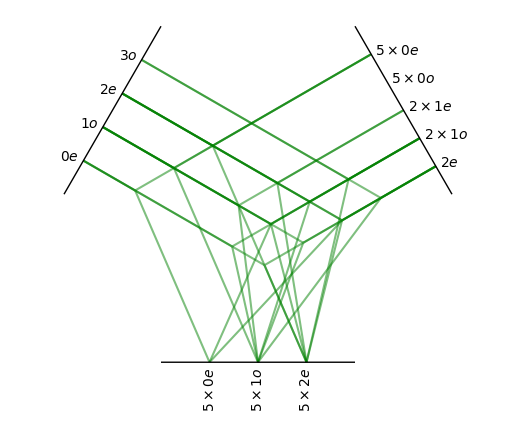

In [75]:
irreps_in1 = o3.Irreps.spherical_harmonics(3)
irreps_sh = o3.Irreps("5x0e + 5x0o + 2x1e + 2x1o + 1x2e") 
irreps_out =  o3.Irreps("5x0e + 5x1o + 5x2e") 
# This will handle the combination of input features and spherical harmonics
tp = FullyConnectedTensorProduct(
   irreps_in1=irreps_in1,    # Input irreducible representations
   irreps_in2=irreps_sh,    # Spherical harmonics irreps
   irreps_out=irreps_out,   # Output irreps
   internal_weights=False,  # Weights will be provided externally from a MLP
   shared_weights=False,    # Each output channel has its own weight
   )

tp.visualize()



In [76]:
print('weight number = ',tp.weight_numel)


def count_weight_number(irreps_in1, irreps_in2, irreps_out):
    instr = [
            (i_1, i_2, i_out, "uvw", True, 1.0)
            for i_1, (_, ir_1) in enumerate(irreps_in1)
            for i_2, (_, ir_2) in enumerate(irreps_in2)
            for i_out, (_, ir_out) in enumerate(irreps_out)
            if ir_out in ir_1 * ir_2
    ]
    count = 0   
    for x in instr:
        i_1, i_2, i_out,_,_,_ = x 
        count = count + irreps_in1[i_1].mul * irreps_in2[i_2].mul * irreps_out[i_out].mul
    print('my count weight number =',count)
    return count
count_weight_number(irreps_in1, irreps_sh, irreps_out);

weight number =  170
my count weight number = 170


In [77]:
# check the equivariance of e3nn's tensor product 
print(' # of channel =', tp.weight_numel)
for i in range(10):
   alpha, beta, gamma = torch.rand([3])*torch.pi
   nedges = 1
   D_in1 = irreps_in1.D_from_angles(alpha, beta, gamma)
   D_sh = irreps_sh.D_from_angles(alpha, beta, gamma)
   D_out = irreps_out.D_from_angles(alpha, beta, gamma)

   node_features = torch.rand([1, irreps_in1.dim])
   edge_attr = torch.rand([1, irreps_sh.dim]) 
   rand_weight = torch.rand([1, tp.weight_numel])
   new_feature = tp(node_features, edge_attr, rand_weight)
   new_feature[0] = torch.matmul(D_out, new_feature[0])

   node_features[0] = torch.matmul(D_in1, node_features[0])
   edge_attr[0] = torch.matmul(D_sh, edge_attr[0])
   new_feature_2 = tp(node_features, edge_attr, rand_weight)
   
   print('equvariance error of tensor product = ', torch.max(torch.abs(new_feature_2 - new_feature)))

 # of channel = 170
equvariance error of tensor product =  tensor(5.3644e-07)
equvariance error of tensor product =  tensor(2.0862e-06)
equvariance error of tensor product =  tensor(5.9605e-07)
equvariance error of tensor product =  tensor(5.6624e-07)
equvariance error of tensor product =  tensor(8.0466e-07)
equvariance error of tensor product =  tensor(2.2426e-06)
equvariance error of tensor product =  tensor(7.7486e-07)
equvariance error of tensor product =  tensor(8.3447e-07)
equvariance error of tensor product =  tensor(2.3842e-07)
equvariance error of tensor product =  tensor(2.3842e-07)
